In [1]:
import numpy as np
import multiprocessing as mp
from multiprocessing import Pool, cpu_count
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import fetch_openml
import os.path
import cv2
import matplotlib.pyplot as plt
from ctypes import *

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
    
def saveImages(mnist):
  for i in range(len(mnist)):
    digit = mnist[i].reshape(28, 28)
    img = PIL.Image.fromarray(digit, mode="L")
    img.save("mnist{}.png".format(i + 1), mode = "L")
    from google.colab import files
    files.download("mnist/images/mnist{}.png".format(i + 1)) 
    
def saveLabels(labels):
    f = open("mnist/labels/labels.txt", "r")
    for i in range(len(labels)):
        f.write("{},".format(labels[i]))
    f.close()

        

In [3]:
SO_DIRPATH = "../libs/"

In [4]:
# Loop Counter
SO_FILE_COUNTER = SO_DIRPATH + 'libcounter.so'
counter_c = CDLL(SO_FILE_COUNTER)
counter_c.python_loop_count.argtypes = [np.ctypeslib.ndpointer(dtype=c_ubyte, flags="C_CONTIGUOUS"), c_int, c_int]
counter_c.python_loop_count.restypes = c_int

In [5]:
def loop_count_c(img, nx, ny):
    shape = np.shape(img)
    if not isinstance(img, np.ndarray): 
        raise TypeError("Image must be a ndarray, get {}".format(type(img).__name__))
    assert (len(shape) == 1), "Image must be serialized"
    
    try:
        cnt = counter_c.python_loop_count(img, nx, ny)
    except Exception as e:
        print("Exception occured: {}".format(e))
        print("If error caused by undefined counter. Make sure to load counter_c library first before running this function\n")
        print("Make sure to defined the restype and argtype of python_loop_count")
        exit(-1)
        
    return cnt

In [6]:
def readImages(path):
    return cv2.imread(path, 0)

def readTrain():
    IMG_TRAIN = "../../mnist/images/train_images"
    LABELS_TRAIN = "../../mnist/labels/train_labels/train.txt"
    # read labels
    with open(LABELS_TRAIN, "r") as f:
        labels = f.read()
    labels = list(map(lambda x: int(x), labels.split(",")))
    assert len(labels) == 60000, "Corrupted labels. Expected {} got {}".format(60000, len(labels))
    data = [os.path.join(IMG_TRAIN, "number{}.png".format(i + 1)) for i in range(60000)]
    with Pool(cpu_count()) as pool:
        train_img = pool.map(readImages, data)
    return [train_img, np.array(labels).reshape(-1, 1)]

In [7]:
train = readTrain()

In [8]:
train_images = train[0]
labels = train[1]

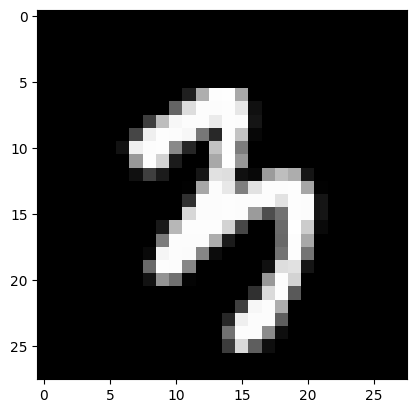

In [9]:
plt.imshow(train_images[5370], cmap='gray')

In [10]:
import sys
import threading
def loop(some_digit):
    global n_finished
    shape = some_digit.reshape(1, -1)[0]
    cnt = loop_count_c(shape, 28, 28) 
    some_digit = np.append(shape, cnt)
    with n_finished.get_lock():
        n_finished.value += 1;
    return some_digit

In [11]:
def process(process_fnc, args):
    with Pool(cpu_count()) as pool:
        X = pool.map(process_fnc, args)

In [17]:
n_finished = mp.Value('i', 0)
t = threading.Thread(target = process, args=(loop, train_images[:6000], ))
t.start()
while t.is_alive():
    sys.stdout.write('\r' + "n_finished={}".format(n_finished.value))
    sys.stdout.flush()

n_finished=3859

Process ForkPoolWorker-106:
Process ForkPoolWorker-103:
Process ForkPoolWorker-110:
Process ForkPoolWorker-111:
Process ForkPoolWorker-109:
Process ForkPoolWorker-112:
Process ForkPoolWorker-105:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-100:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multi

n_finished=3038

  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self.

n_finished=3290

KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


n_finished=2587

KeyboardInterrupt: 

In [ ]:
X_train, y_train = X, train[1]

In [ ]:
# check loop count
for i in range(60000):
    print(X_train[i][784], y_train[i][0])